In [12]:
import enum

import numpy

from numpy import random
from matplotlib import pyplot
from scipy import stats

_BASE_SEED = """This is a pretty long string. I am making some odd decisions with it?
Who shall say this is not a pretty entropic thing I'm rwriting, I tell you hwaht."""

In [13]:
def seed(s: str) -> int:
    return abs(hash(_BASE_SEED + s)) % (2 ** 32)

## 5.1, Discrete probability simulation

> Suppose that a basketball player has a 60% chance of making a shot, and he
> keeps taking shots until he misses two in a row. Also assume his shots are
> independent (so that each shot has 60% probability of success, no matter what
> happened before).
>
> (a) Write an R function to simulate this process.
>
> (b) Put the R function in a loop to simulate the process 1000 times. Use the
> simulation to estimate the mean and standard deviation of the total number of
> shots that the player will take, and plot a histogram representing the
> distribution of this random variable.
>
> (c) Using your simulations, make a scatterplot of the number of shots the
> player will take and the proportion of shots that are successes.

In [14]:
rng = random.default_rng(seed=seed('Example 5.1'))

In [15]:
def shooting_session() -> (int, int):
    """Returns number of baskets, number of shots."""
    missed_last_time = False
    shots = 0
    hits = 0
    while True:
        shots += 1
        if rng.random() > 0.6:
            if missed_last_time:
                break
            missed_last_time = True
        else:
            hits += 1
            missed_last_time = False
    return hits, shots

In [16]:
sessions = [shooting_session() for _ in range(1000)]
shot_counts = [t[1] for t in sessions]
print(f'Mean:     {numpy.mean(shot_counts):0.2f}')
print(f'Std. Dev: {numpy.std(shot_counts):0.2f}')

Mean:     8.84
Std. Dev: 7.65


In [23]:
def histogram_basketball(shot_counts: list[int]):
    fig = pyplot.figure(figsize=(7, 5))
    ax = fig.gca()
    ax.hist(shot_counts, bins=max(shot_counts), range=(0, max(shot_counts)),
            align='left')
    ax.set_xlabel('Number of shots')
    ax.set_ylabel('Number of simulations')
    ax.set_xlim(0, 1 + max(shot_counts))
    ax.grid()

In [21]:
def scatter_basketball(hits_and_counts: list[tuple[int, int]]):
    # Add some jitter to the shot counts:
    xs = [rng.uniform(-0.15, 0.15) + count for _, count in hits_and_counts]
    # And also to the proportion:
    ys = [rng.uniform(-0.02, 0.02) + float(hits) / count for (hits, count) in hits_and_counts]
    fig = pyplot.figure(figsize=(7, 5))
    ax = fig.gca()
    ax.set_xlabel('Shots taken')
    ax.set_ylabel('Success rate')
    ax.scatter(xs, ys, s=2, alpha=0.8)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-0.5, max(shot_counts) + 0.5)
    ax.grid()

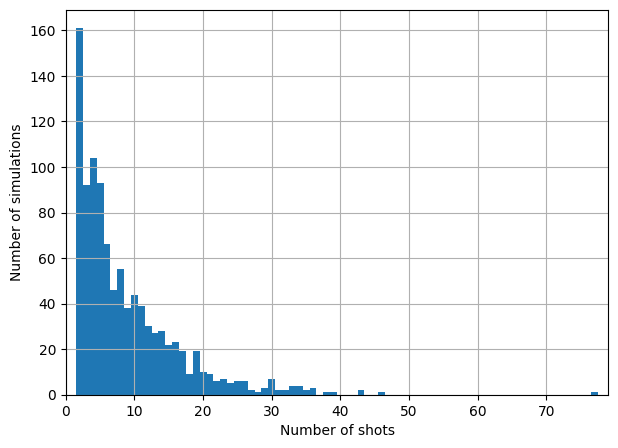

In [24]:
histogram_basketball(shot_counts)

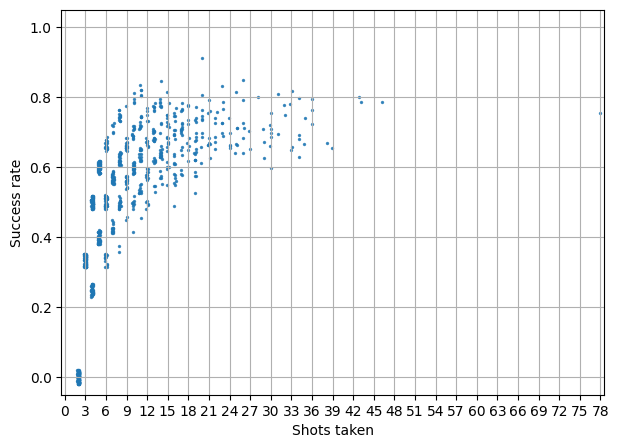

In [20]:
scatter_basketball(sessions)

## 5.2, Continuous probability simulation

> The logarithms of weights (in pounds) of men in the United States are
> approximately normally distributed with mean 5.13 and standard deviation 0.17;
> women’s log weights are approximately normally distributed with mean 4.96 and
> standard deviation 0.20. Suppose 10 adults selected at random step on an
> elevator with a capacity of 1750 pounds. What is the probability that their
> total weight exceeds this limit?

In [13]:
rng = random.default_rng(seed=seed('Example 5.2'))

In [14]:
def sample_weight() -> float:
    """Sample one US person's weight."""
    return numpy.exp(
        rng.normal(4.96, 0.2)
        if rng.uniform() < 0.5
        else rng.normal(5.13, 0.17)
    )

def exceeds_weight() -> bool:
    total_weight = 0
    for _ in range(10):
        total_weight += sample_weight()
        if total_weight > 1750:
            return True
    return False        

In [15]:
num_sims = 100_000
num_exceeds = sum(1 if exceeds_weight() else 0 for _ in range(num_sims))
exceed_rate = float(num_exceeds) / num_sims
std_err = numpy.sqrt(exceed_rate * (1 - exceed_rate) / num_sims)

print(f'{100 * exceed_rate:0.1f}% +/- {200 * std_err:0.2f}%')
print(f'[{100 * (exceed_rate - 2 * std_err):0.2f}%, {100 * (exceed_rate + 2 * std_err):0.2f}%]')

5.6% +/- 0.15%
[5.49%, 5.78%]


## 5.3, Binomial distribution

> A player takes 10 basketball shots, with a 40% probability of making each
> shot. Assume the outcomes of the shots are independent. 
>
> (a) Write a line of R code to compute the probability that the player makes
> exactly 3 of the 10 shots.
>
> (b) Write an R function to simulate the 10 shots. Loop this function 10,000
> times and check that your simulated probability of making exactly 3 shots is
> close to the exact probability computed in (a).

In [16]:
rng = random.default_rng(seed=seed('Example 5.3'))

In [17]:
official_answer = stats.binom.pmf(3, 10, 0.4)
print(f'Official chance: {100*official_answer:0.1f}%')

Official chance: 21.5%


In [18]:
def hits_three_of_ten() -> bool:
    """Does our shooter hit *exactly* 3 of 10 shots?"""
    hits = 0
    for _ in range(10):
        is_hit = (rng.uniform() < 0.4)
        if is_hit:
            hits += 1
            if hits == 4:
                return False
    return hits == 3

In [19]:
num_sims = 10_000
three_hits = sum(1 if hits_three_of_ten() else 0 for _ in range(num_sims))
three_hits_rate = float(three_hits) / num_sims
std_err = numpy.sqrt(three_hits_rate * (1 - three_hits_rate) / num_sims)
print(f'{100 * three_hits_rate:0.1f}% +/- {200 * std_err:0.2f}%')
print(f'[{100 * (three_hits_rate - 2 * std_err):0.2f}%, {100 * (three_hits_rate + 2 * std_err):0.2f}%]')

21.7% +/- 0.82%
[20.86%, 22.50%]


## 5.4, Demonstration of the Central Limit Theorem

> Let $x = x_1 + \ldots + x_{20}$, the sum of 20 independent uniform(0; 1)
> random variables. In R, create 1000 simulations of $x$ and plot their
> histogram. > What is the normal approximation to this distribution provided by
> the Central Limit Theorem? Overlay a graph of the normal density on top of the
> histogram. Comment on any differences between the histogram and the curve.

In [20]:
rng = random.default_rng(seed=seed('Example 5.4'))

/tmp/ipykernel_586/2073527453.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['' for _ in ytlabels])


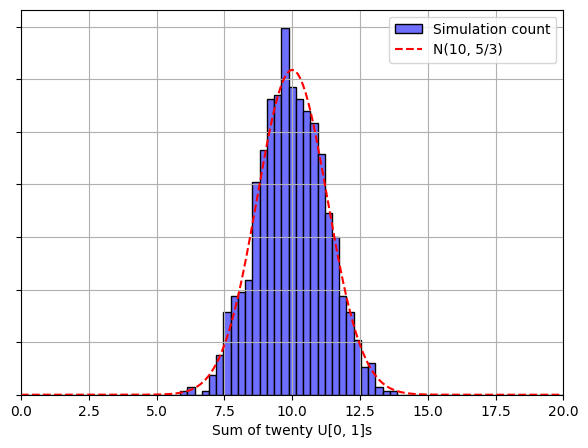

In [21]:
num_sims = 1000
sims = rng.uniform(0, 1, (num_sims, 20)).sum(axis=1)
fig = pyplot.figure(figsize=(7, 5))
ax = fig.gca()
ax.hist(sims, bins=75, range=(0, 20), edgecolor='black', color='#6F6FFF',
        density=True, label='Simulation count')
ax.set_xlabel('Sum of twenty U[0, 1]s')
ax.set_xlim(0, 20)

pdf_xs = numpy.arange(0, 20, 0.1)
pdf_ys = [stats.norm.pdf(xi, loc=10, scale=numpy.sqrt(20/12)) for xi in pdf_xs]
ytlabels = ax.get_yticklabels()
ax.set_yticklabels(['' for _ in ytlabels])
ax.plot(pdf_xs, pdf_ys, 'r--', label='N(10, 5/3)')
ax.legend()
ax.grid()

## 5.5, Distribution of averages and differences

> The heights of men in the United States are approximately normally distributed
> with mean 69.1 inches and standard deviation 2.9 inches. The heights of women
> are approximately normally distributed with mean 63.7 inches and standard
> deviation 2.7 inches. Let $x$ be the average height of 100 randomly sampled
> men, and $y$ be the average height of 100 randomly sampled women. In R, create
> 1000 simulations of $x - y$ and plot their histogram. Using the simulations,
> compute the mean and standard deviation of the distribution of $x - y$ and
> compare to their exact values.

In [22]:
rng = random.default_rng(seed=seed('Example 5.5'))

In [23]:
def diff_of_avg_heights() -> float:
    """Finds the sample mean height of 100 men and 100 women, returns the diff."""
    men_avg = rng.normal(69.1, 2.9, 100).mean()
    women_avg = rng.normal(63.7, 2.7, 100).mean()    
    return men_avg - women_avg

In [24]:
num_sims = 1000
sim_diffs = [diff_of_avg_heights() for _ in range(num_sims)]

In [25]:
print(numpy.sqrt(0.27**2 + 0.29**2))
print(69.1-63.7)

0.396232255123179
5.3999999999999915


/tmp/ipykernel_586/2860777725.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['' for _ in ytlabels])


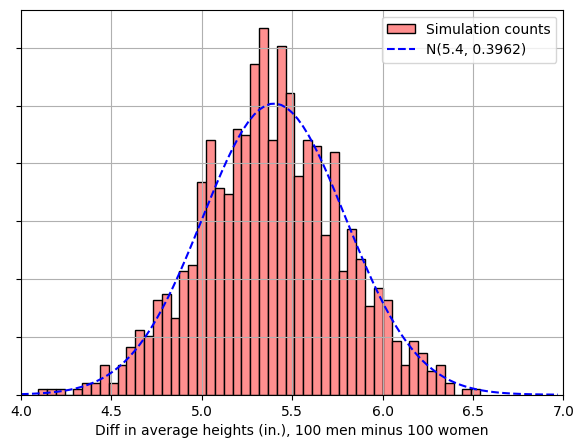

In [26]:
fig = pyplot.figure(figsize=(7, 5))
ax = fig.gca()
ax.hist(sim_diffs, edgecolor='black', color='#FF8F8F', bins=50,
        density=True, label='Simulation counts')
ax.set_xlabel('Diff in average heights (in.), 100 men minus 100 women')
ax.set_xlim(4, 7)
ytlabels = ax.get_yticklabels()
ax.set_yticklabels(['' for _ in ytlabels])

pdf_xs = numpy.arange(4, 7, 0.03)
pdf_ys = [stats.norm.pdf(xi, loc=5.4, scale=0.3962) for xi in pdf_xs]
ax.plot(pdf_xs, pdf_ys, 'b--', label='N(5.4, 0.3962)')
ax.grid()
ax.legend()

## 5.6, Propagation of uncertainty

> We use a highly idealized setting to illustrate the use of simulations in
> combining uncertainties. Suppose a company changes its technology for widget
> production, and a study estimates the cost savings at \\$5 per unit, but with a
> standard error of \\$4. Furthermore, a forecast estimates the size of the market
> (that is, the number of widgets that will be sold) at 40 000, with a standard
> error of 10 000. Assuming these two sources of uncertainty are independent,
> use simulation to estimate the total amount of money saved by the new product
> (that is, savings per unit, multiplied by size of the market).

In [27]:
rng = random.default_rng(seed=seed('Example 5.6'))

In [28]:
num_sims = 10_000
unit_savings = rng.normal(5, 4, num_sims)
market_sizes = stats.truncnorm.rvs(-4, 1000, loc=40, scale=10, size=num_sims, random_state=rng)
total_savings = [usi * msi for (usi, msi) in zip(unit_savings, market_sizes)]

In [29]:
print(f'Mean Savings: ${numpy.mean(total_savings):0.1f}K')
print(f'Std. Dev: ${numpy.std(total_savings):0.1f}K')
(p025, p25, p75, p975) = numpy.percentile(total_savings, [2.5, 25, 75, 97.5])
print(f'Interquartile Range: ${p25:0.1f}K to ${p75:0.1f}')
print(f'95% coverage: ${p025:0.1f}K to ${p975:0.1f}')

Mean Savings: $201.0K
Std. Dev: $175.7K
Interquartile Range: $84.5K to $309.2
95% coverage: $-116.8K to $578.3


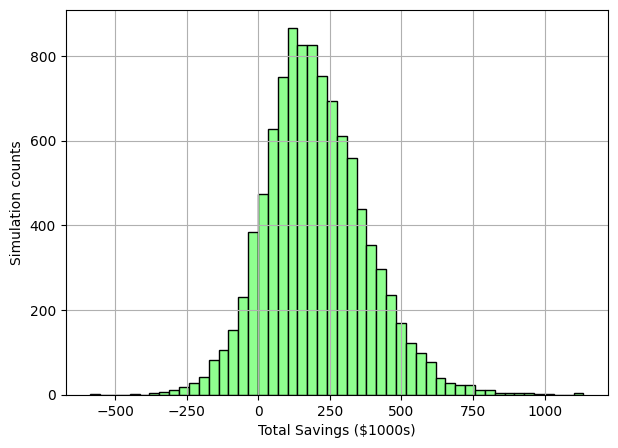

In [30]:
fig = pyplot.figure(figsize=(7, 5))
ax = fig.gca()
ax.hist(total_savings, edgecolor='black', color='#8FFF8F', bins=50)
ax.set_xlabel('Total Savings ($1000s)')
ax.set_ylabel('Simulation counts')
ax.grid()

## 5.7, Coverage of confidence intervals

> Reconstruct the graph in Figure 4.2. The simulations are for an estimate whose
> sampling distribution has mean 6 and standard deviation 4.

In [31]:
rng = random.default_rng(seed=seed('Example 5.7'))

In [32]:
means = rng.normal(loc=6, scale=4, size=100)
(q025, q25, q75, q975) = stats.norm.ppf([0.025, 0.25, 0.75, 0.975])

Text(0, 0.5, 'Estimate, 50%, and 95% coverage interval')

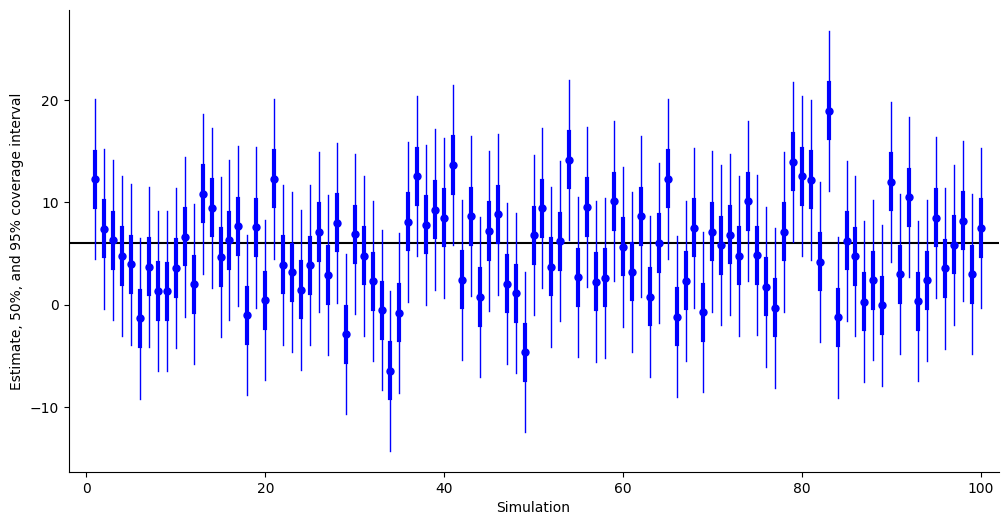

In [33]:
fig = pyplot.figure(figsize=(12, 6))
ax = fig.gca()
ax.axhline(color='k', y=6, zorder=0)
xs = list(range(1, 101))
ax.plot(xs, means, 'bo', markersize=5, linewidth=0)
for xi, mi in zip(xs, means):
    ax.plot([xi, xi], [mi + q025 * 4, mi + q975 * 4], 'b', markersize=0, linewidth=1)
    ax.plot([xi, xi], [mi + q25 * 4, mi + q75 * 4], 'b', markersize=0, linewidth=3)
ax.set_xlabel('Simulation')
ax.set_xlim(-2, 102)
for side in ('top', 'right'):
    ax.spines[side].set_visible(False)
ax.set_ylabel('Estimate, 50%, and 95% coverage interval')

## 5.8, Coverage of confidence intervals

> On page 15 there is a discussion of an experimental study of an
> education-related intervention in Jamaica, in which the point estimate of the
> treatment effect, on the log scale, was 0.35 with a standard error of 0.17.
> Suppose the true effect is 0.10 — this seems more realistic than the point
> estimate of 0.35 — so that the treatment on average would increase earnings by
> 0.10 on the log scale. Use simulation to study the statistical properties of
> this experiment, assuming the standard error is 0.17.
>
> (a) Simulate 1000 independent replications of the experiment assuming that the
>     point estimate is normally distributed with mean 0.10 and standard
>     deviation 0.17.
>
> (b) For each replication, compute the 95% confidence interval. Check how many
>     of these intervals include the true parameter value.
>
> (c) Compute the average and standard deviation of the 1000 point estimates;
>     these represent the mean and standard deviation of the sampling
>     distribution of the estimated treatment effect.

In [34]:
rng = random.default_rng(seed=seed('Example 5.8'))

In [35]:
jamaica_effects = rng.normal(loc=0.1, scale=0.17, size=1000)
jamaica_intervals = [(je + q025 * 0.17, je + q975 * 0.17) for je in jamaica_effects]
includes_true = sum(lo <= 0.1 <= hi for (lo, hi) in jamaica_intervals)
print(f'{includes_true} replications included the true effect size.')
print(f'Mean: {jamaica_effects.mean():0.2f}\nStd. Dev: {jamaica_effects.std():0.2f}')

942 replications included the true effect size.
Mean: 0.11
Std. Dev: 0.18


## 5.9, Coverage of confidence intervals after selection on statistical significance

> Take your 1000 simulations from Exercise 5.8, and select just the ones where
> the estimate is statistically significantly different from zero. Compute the
> average and standard deviation of the selected point estimates. Compare these
> to the result from Exercise 5.8.

In [36]:
stat_sig_effects = []
for je, (lo, hi) in zip(jamaica_effects, jamaica_intervals):
    if lo > 0 or hi < 0:
        stat_sig_effects.append(je)
print(f'{len(stat_sig_effects)} significant findings')
print(f'Mean: {numpy.mean(stat_sig_effects):0.2f}\nStd. Dev: {numpy.std(stat_sig_effects):0.2f}')

106 significant findings
Mean: 0.38
Std. Dev: 0.18


## 5.10, Inference for a ratio of parameters

> A (hypothetical) study compares the costs and effectiveness of two different
> medical treatments.
>
> * In the first part of the study, the difference in costs between treatments
>   A and B is estimated at \\$600 per patient, with a standard error of \\$400,
>   based on a regression with 50 degrees of freedom.
> * In the second part of the study, the difference in effectiveness is
>   estimated at 3.0 (on some relevant measure), with a standard error of 1.0,
>   based on a regression with 100 degrees of freedom.
> * For simplicity, assume that the data from the two parts of the study were
>   collected independently. Inference is desired for the incremental
>   cost-effectiveness ratio: the difference between the average costs of the
>   two treatments, divided by the difference between their average
>   effectiveness, a problem discussed further by Heitjan, Moskowitz, and
>   Whang (1999).
>
> (a) Create 1000 simulation draws of the cost difference and the effectiveness
>     difference, and make a scatterplot of these draws.
>
> (b) Use simulation to come up with an estimate, 50% interval, and 95% interval
>     for the incremental cost-effectiveness ratio.
>
> (c) Repeat, changing the standard error on the difference in effectiveness to
>     2.0.

In [37]:
rng = random.default_rng(seed=seed('Example 5.10'))

In [38]:
costs = stats.t.rvs(50, loc=600, scale=400, size=1000, random_state=rng)
effects = stats.t.rvs(100, loc=3, scale=1, size=1000, random_state=rng)

In [39]:
def cost_effect_scatter(costs, effects):
    fig = pyplot.figure(figsize=(7, 5))
    ax = fig.gca()
    ax.plot(costs, effects, 'b.')
    for side in ('top', 'right', 'bottom', 'left'):
        ax.spines[side].set_visible(False)
    ax.set_xlabel('Cost difference')
    ax.set_ylabel('Treatment effect')
    ax.grid()

In [40]:
def summarize_incremental_cost_effectiveness(costs, effects):
    ratios = [cost / effect for (cost, effect) in zip(costs, effects)]
    ratio_mean = numpy.mean(ratios)
    q025, q25, q75, q975 = numpy.percentile(ratios, [2.5, 25, 75, 97.5])
    print(f'Mean ratio: {ratio_mean:0.3f}')
    print(f'50% interval: {q25:0.3f} to {q75:0.3f}')
    print(f'95% interval: {q025:0.3f} to {q975:0.3f}')

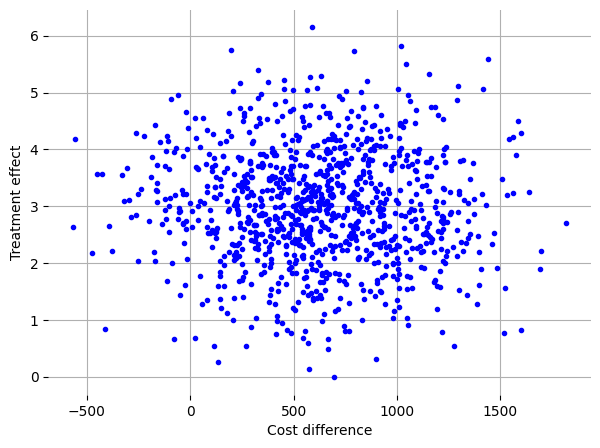

In [41]:
cost_effect_scatter(costs, effects)

In [42]:
summarize_incremental_cost_effectiveness(costs, effects)

Mean ratio: 183.062
50% interval: 112.432 to 326.376
95% interval: -52.786 to 803.683


In [43]:
# Repeat:
costs = stats.t.rvs(50, loc=600, scale=400, size=1000, random_state=rng)
effects = stats.t.rvs(100, loc=3, scale=2, size=1000, random_state=rng)

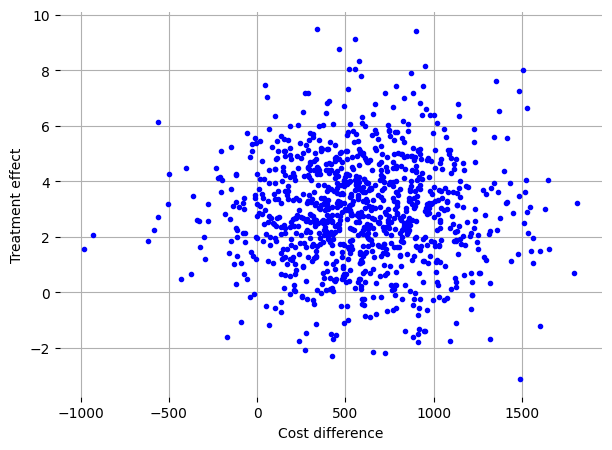

In [44]:
cost_effect_scatter(costs, effects)

In [45]:
summarize_incremental_cost_effectiveness(costs, effects)

Mean ratio: 203.222
50% interval: 70.991 to 314.666
95% interval: -1339.754 to 2542.320


## 5.12, Randomization

> Write a function in R to assign $n$ items to treatment and control conditions
> under the following assignment procedures:
>
> * Independent random assignment. Each item is independently randomly assigned
>   to treatment or control with probabilities $p$ and $1 - p$.
> * Complete random assignment. The $n$ items are randomly partitioned into $np$
>   items that receive the treatment, and the other $n(1 - p)$ are assigned to
>   control.
> * Matched pairs. This is the simplest version of block random assignment. The
>   $n$ items come sequentially in $n/2$ pairs. Within each pair, one item is
>   randomly chosen for treatment and one for control. In other words,
>   $p = 0.5$.
>
> Write one R function, not three. Your function should have three inputs: $n$,
> $p$, and a code for which procedure to use. The output should be a vector of
> treatment assignments (1’s and 0’s). Hint: Your function likely won’t work for
> all combinations of $n$ and $p$. If it doesn’t, write it so that it throws an
> error and alerts the user.

In [46]:
@enum.unique
class RandomAssignmentProcedure(enum.Enum):
    INDEPENDENT = 1
    COMPLETE = 2
    MATCHED = 3

In [47]:
def _independent(n: int, p: float) -> tuple[int]:
    rng = random.default_rng()
    return tuple(
        1 if rng.random() < p else 0
        for _ in range(n)
    )

In [48]:
def _complete(n: int, p: float) -> tuple[int]:
    rng = random.default_rng()
    out = [0 for _ in range(n)]
    for i in rng.choice(list(range(n)), size=round(n * p), replace=False):
        out[i] = 1
    return out

In [49]:
def _matched(n: int) -> tuple[int]:
    if n % 2 != 0:
        raise ValueError(f'Cannot perform MATCHED assignment when n is odd; got n = {n}')
    rng = random.default_rng()
    out = [0 for _ in range(n)]
    for i in range(n / 2):
        if rng.random() < 0.5:
            out[i] = 1
        else:
            out[i + 1] = 1
    return out    

In [50]:
def random_assignments(n: int, p: float, procedure: RandomAssignmentProcedure) -> tuple[int]:
    if procedure is RandomAssignmentProcedure.INDEPENDENT:
        return _independent(n, p)
    if procedure is RandomAssignmentProcedure.COMPLETE:
        return _complete(n, p)
    if procedure is RandomAssignmentProcedure.MATCHED:
        return _matched(n)
    raise ValueError(f'Unsupported assignment procedure "{procedure}"')